In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

/Users/abbieschindler/opt/anaconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


### RFID data

#### Get paths for files to process

In [2]:
#create list of dir paths
RFID_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r2.1m'
    
RFID_file_names = os.listdir(RFID_path)

RFID_data_dir_paths = []

for file in RFID_file_names:
    int_path = RFID_path + '/' + file
    RFID_data_dir_paths.append(int_path)
    
RFID_data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r2.1m/hardware_test-21.04.02.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r2.1m/.DS_Store',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r2.1m/hardware_test-21.04.07.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r2.1m/hardware_test-21.03.19.csv']

#### Clean df and combine into 1

In [3]:
data_RFID = pd.DataFrame()

for path in RFID_data_dir_paths:
    print(path)
    
    if path.split('/')[-1] == '.DS_Store':
        continue
        
    #create data table
    data_RFID_int = pd.read_csv(path, sep=';', encoding='utf-16')
    data_RFID_int = pd.DataFrame(data = data_RFID_int)
    data_RFID_int = data_RFID_int.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

    print(data_RFID_int.shape)
    
    #drop rows with no event duration
    data_RFID_int = data_RFID_int[~data_RFID_int['eventDuration'].isna()]
    
    #convert from ms to sec
    data_RFID_int['eventDuration'] = data_RFID_int['eventDuration']/1000
    #clean up and create datetime columns
    data_RFID_int['start_datetime'] = pd.to_datetime(data_RFID_int['DateTime'], unit='d')
    #can't figure out datetime format so hard code for now
    data_RFID_int['RFID_datetime_start'] = [x.replace(year = 2021) - dt.timedelta(days = 2) for x in data_RFID_int['start_datetime']] 
    data_RFID_int['RFID_date'] = data_RFID_int['RFID_datetime_start'].dt.date 
    data_RFID_int['RFID_day'] = data_RFID_int['RFID_datetime_start'].dt.day 
    data_RFID_int['RFID_time_start'] = [x.split(' ')[1] for x in data_RFID_int['RFID_datetime_start'].dt.strftime("%Y-%m-%d %H:%M:%S")]
    data_RFID_int['RFID_hour'] = data_RFID_int['RFID_datetime_start'].dt.hour
    data_RFID_int['RFID_min'] = data_RFID_int['RFID_datetime_start'].dt.minute
    data_RFID_int['RFID_second'] = data_RFID_int['RFID_datetime_start'].dt.second

    if data_RFID.empty:
        data_RFID = data_RFID_int
    else:
        data_RFID = pd.concat([data_RFID, data_RFID_int], axis=0)
        
    print(data_RFID.shape,'\n')

#clean columns
data_RFID = data_RFID[['IdRFID', 'unitLabel', 'eventDuration',
       'RFID_datetime_start', 'RFID_date',
       'RFID_day', 'RFID_time_start', 'RFID_hour', 'RFID_min', 'RFID_second']]
    
data_RFID.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r2.1m/hardware_test-21.04.02.csv
(69848, 14)
(69847, 22) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r2.1m/.DS_Store
/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r2.1m/hardware_test-21.04.07.csv
(96969, 14)
(166815, 22) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r2.1m/hardware_test-21.03.19.csv
(163026, 14)
(329840, 22) 



,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second
17,041A5552E4,AM1-11,1.744,2021-04-02 13:19:11.566012800,2021-04-02,2,13:19:11,13,19,11
18,041A555E76,AM1-11,0.412,2021-04-02 13:19:13.527033600,2021-04-02,2,13:19:13,13,19,13
19,041A5552E4,AM1-11,0.873,2021-04-02 13:19:14.153001599,2021-04-02,2,13:19:14,13,19,14
20,041A555EA7,AM1-15,3.982,2021-04-02 13:19:13.027987199,2021-04-02,2,13:19:13,13,19,13
21,041A555E76,AM1-11,1.264,2021-04-02 13:19:16.739990400,2021-04-02,2,13:19:16,13,19,16


In [4]:
data_RFID['IdRFID'].value_counts()

041A5552E4    39046
041A55602C    36864
041A5553DC    36238
041A555FE0    35871
041A555EFA    35614
041A555E76    34896
041A555FA3    31105
041A55591F    27510
041A555DEE    20045
041A555D58    18407
041A555EA7    14243
041A5541A5    1    
Name: IdRFID, dtype: int64

In [5]:
data_RFID = data_RFID[data_RFID['IdRFID'] != '041A5541A5']

#### Compute endtime 

In [6]:
#compute end time for each eventDuration
def add_duration(a, b):
    newtime = a + dt.timedelta(0, b)

    return newtime

data_RFID['RFID_datetime_end'] = data_RFID.apply(lambda row: add_duration(row['RFID_datetime_start'], row['eventDuration']), axis=1)
data_RFID['RFID_time_end'] = [x.split(' ')[1] for x in data_RFID['RFID_datetime_end'].dt.strftime("%Y-%m-%d %H:%M:%S")]

print(data_RFID.shape)
data_RFID.head()

(329839, 12)


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end
17,041A5552E4,AM1-11,1.744,2021-04-02 13:19:11.566012800,2021-04-02,2,13:19:11,13,19,11,2021-04-02 13:19:13.310012800,13:19:13
18,041A555E76,AM1-11,0.412,2021-04-02 13:19:13.527033600,2021-04-02,2,13:19:13,13,19,13,2021-04-02 13:19:13.939033600,13:19:13
19,041A5552E4,AM1-11,0.873,2021-04-02 13:19:14.153001599,2021-04-02,2,13:19:14,13,19,14,2021-04-02 13:19:15.026001599,13:19:15
20,041A555EA7,AM1-15,3.982,2021-04-02 13:19:13.027987199,2021-04-02,2,13:19:13,13,19,13,2021-04-02 13:19:17.009987199,13:19:17
21,041A555E76,AM1-11,1.264,2021-04-02 13:19:16.739990400,2021-04-02,2,13:19:16,13,19,16,2021-04-02 13:19:18.003990400,13:19:18


#### Add next column (do for each unitLabel separately)

In [7]:
#column for if next is same Id
def next_compare(a, b):
    if a == b:
        compare = 'same'
        
    if a != b:
        compare = 'diff'

    return compare

data_RFID_next = pd.DataFrame()

for unitlabel in data_RFID['unitLabel'].unique():
    print(unitlabel)

    data_int = data_RFID[data_RFID['unitLabel'] == unitlabel].sort_values(['RFID_datetime_start'])
    data_int['RFID_datetime_start_next'] = data_int['RFID_datetime_start'].shift(-1)
    data_int['IdRFID_next'] = data_int['IdRFID'].shift(-1)
    
    data_int['IdRFID_diff_next'] = data_int.apply(lambda row: next_compare(row['IdRFID'], row['IdRFID_next']), axis=1)

    if data_RFID_next.empty:
        data_RFID_next = data_int
    else:
        data_RFID_next = pd.concat([data_RFID_next, data_int], axis=0)

data_RFID_next['time_diff_next'] = (data_RFID_next['RFID_datetime_start_next'] - data_RFID_next['RFID_datetime_end'])
data_RFID_next['time_diff_next'] = [x.total_seconds() for x in data_RFID_next['time_diff_next']]
data_RFID_next['time_diff_next_round'] = data_RFID_next['time_diff_next'].round(-1)
data_RFID_next.head()

AM1-11
AM1-15
AM1-12
AM1-9
AM1-6
AM1-10
AM1-8
AM1-4
AM1-5
AM1-2
AM1-3
AM1-1
AM1-16
AM1-14
AM1-13
AM1-7


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round
28,041A5553DC,AM1-11,6.395,2021-03-19 14:08:17.060035200,2021-03-19,19,14:08:17,14,8,17,2021-03-19 14:08:23.455035200,14:08:23,2021-03-19 14:08:24.568972800,041A5553DC,same,1.113937,0.0
30,041A5553DC,AM1-11,3.763,2021-03-19 14:08:24.568972800,2021-03-19,19,14:08:24,14,8,24,2021-03-19 14:08:28.331972800,14:08:28,2021-03-19 14:08:29.945990400,041A5553DC,same,1.614017,0.0
31,041A5553DC,AM1-11,0.458,2021-03-19 14:08:29.945990400,2021-03-19,19,14:08:29,14,8,29,2021-03-19 14:08:30.403990400,14:08:30,2021-03-19 14:08:31.419024000,041A5553DC,same,1.015033,0.0
32,041A5553DC,AM1-11,0.075,2021-03-19 14:08:31.419024000,2021-03-19,19,14:08:31,14,8,31,2021-03-19 14:08:31.494024000,14:08:31,2021-03-19 14:09:45.131961600,041A5553DC,same,73.637937,70.0
38,041A5553DC,AM1-11,1.945,2021-03-19 14:09:45.131961600,2021-03-19,19,14:09:45,14,9,45,2021-03-19 14:09:47.076961600,14:09:47,2021-03-19 14:09:49.092019200,041A5553DC,same,2.015057,0.0


#### Add day, hour, and min counts

In [8]:
#column of running day count
dat_map = dict(zip(data_RFID_next['RFID_date'].unique(), np.arange(1,len(data_RFID_next['RFID_date'].unique())+1)))
data_RFID_next['RFID_day_count'] = data_RFID_next['RFID_date'].map(dat_map)

#column of running min and second count within each day
data_RFID_next['RFID_min_count'] = (data_RFID_next['RFID_hour']*60) + data_RFID_next['RFID_min'] 
data_RFID_next['RFID_sec_count'] = (data_RFID_next['RFID_min_count']*60) + data_RFID_next['RFID_second'] 

#column of running hour and minute count across all days
data_RFID_next['RFID_hour_count_running'] = (data_RFID_next['RFID_day_count']*24) + data_RFID_next['RFID_hour'] - 24
data_RFID_next['RFID_min_count_running'] = (data_RFID_next['RFID_hour_count_running']*60) + data_RFID_next['RFID_min'] 
data_RFID_next['RFID_sec_count_running'] = (data_RFID_next['RFID_min_count_running']*60) + data_RFID_next['RFID_second'] - 60

print(data_RFID_next.shape)
data_RFID_next.head()

(329839, 23)


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running
28,041A5553DC,AM1-11,6.395,2021-03-19 14:08:17.060035200,2021-03-19,19,14:08:17,14,8,17,2021-03-19 14:08:23.455035200,14:08:23,2021-03-19 14:08:24.568972800,041A5553DC,same,1.113937,0.0,1,848,50897,14,848,50837
30,041A5553DC,AM1-11,3.763,2021-03-19 14:08:24.568972800,2021-03-19,19,14:08:24,14,8,24,2021-03-19 14:08:28.331972800,14:08:28,2021-03-19 14:08:29.945990400,041A5553DC,same,1.614017,0.0,1,848,50904,14,848,50844
31,041A5553DC,AM1-11,0.458,2021-03-19 14:08:29.945990400,2021-03-19,19,14:08:29,14,8,29,2021-03-19 14:08:30.403990400,14:08:30,2021-03-19 14:08:31.419024000,041A5553DC,same,1.015033,0.0,1,848,50909,14,848,50849
32,041A5553DC,AM1-11,0.075,2021-03-19 14:08:31.419024000,2021-03-19,19,14:08:31,14,8,31,2021-03-19 14:08:31.494024000,14:08:31,2021-03-19 14:09:45.131961600,041A5553DC,same,73.637937,70.0,1,848,50911,14,848,50851
38,041A5553DC,AM1-11,1.945,2021-03-19 14:09:45.131961600,2021-03-19,19,14:09:45,14,9,45,2021-03-19 14:09:47.076961600,14:09:47,2021-03-19 14:09:49.092019200,041A5553DC,same,2.015057,0.0,1,849,50985,14,849,50925


#### Add light dark

In [10]:
def assign_ld(time):
    if (time >= 6) & (time < 18):
        return 'light'
    if (time >= 0) & (time < 6):
        return 'dark_am'
    if (time >= 18):
        return 'dark_pm'
    
data_RFID_next['ld_seg'] = data_RFID_next['RFID_hour'].apply(assign_ld)

print(data_RFID_next.shape)
data_RFID_next.head()


(329839, 24)


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg
28,041A5553DC,AM1-11,6.395,2021-03-19 14:08:17.060035200,2021-03-19,19,14:08:17,14,8,17,2021-03-19 14:08:23.455035200,14:08:23,2021-03-19 14:08:24.568972800,041A5553DC,same,1.113937,0.0,1,848,50897,14,848,50837,light
30,041A5553DC,AM1-11,3.763,2021-03-19 14:08:24.568972800,2021-03-19,19,14:08:24,14,8,24,2021-03-19 14:08:28.331972800,14:08:28,2021-03-19 14:08:29.945990400,041A5553DC,same,1.614017,0.0,1,848,50904,14,848,50844,light
31,041A5553DC,AM1-11,0.458,2021-03-19 14:08:29.945990400,2021-03-19,19,14:08:29,14,8,29,2021-03-19 14:08:30.403990400,14:08:30,2021-03-19 14:08:31.419024000,041A5553DC,same,1.015033,0.0,1,848,50909,14,848,50849,light
32,041A5553DC,AM1-11,0.075,2021-03-19 14:08:31.419024000,2021-03-19,19,14:08:31,14,8,31,2021-03-19 14:08:31.494024000,14:08:31,2021-03-19 14:09:45.131961600,041A5553DC,same,73.637937,70.0,1,848,50911,14,848,50851,light
38,041A5553DC,AM1-11,1.945,2021-03-19 14:09:45.131961600,2021-03-19,19,14:09:45,14,9,45,2021-03-19 14:09:47.076961600,14:09:47,2021-03-19 14:09:49.092019200,041A5553DC,same,2.015057,0.0,1,849,50985,14,849,50925,light


#### Add day/night mapping (lines up dates and ld segments)

In [11]:
ld_mapping_path = '/Users/abbieschindler/Documents/ProgrammingFun/iPythonScripts/ld_mapping.xlsx'

ld_mapping = pd.read_excel(ld_mapping_path)
ld_mapping = pd.DataFrame(data = ld_mapping)
print(ld_mapping.shape)
ld_mapping.head()

(89, 3)


,day,ld_seg,ld
0,2,dark_am,dark_night1
1,3,dark_am,dark_night2
2,4,dark_am,dark_night3
3,5,dark_am,dark_night4
4,6,dark_am,dark_night5


In [12]:
data_RFID_next = data_RFID_next.merge(ld_mapping, right_on=['day', 'ld_seg'], left_on=['RFID_day_count', 'ld_seg'])
print(data_RFID_next.shape)
data_RFID_next.head()

(329839, 26)


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg,day,ld
0,041A5553DC,AM1-11,6.395,2021-03-19 14:08:17.060035200,2021-03-19,19,14:08:17,14,8,17,2021-03-19 14:08:23.455035200,14:08:23,2021-03-19 14:08:24.568972800,041A5553DC,same,1.113937,0.0,1,848,50897,14,848,50837,light,1,light_day1
1,041A5553DC,AM1-11,3.763,2021-03-19 14:08:24.568972800,2021-03-19,19,14:08:24,14,8,24,2021-03-19 14:08:28.331972800,14:08:28,2021-03-19 14:08:29.945990400,041A5553DC,same,1.614017,0.0,1,848,50904,14,848,50844,light,1,light_day1
2,041A5553DC,AM1-11,0.458,2021-03-19 14:08:29.945990400,2021-03-19,19,14:08:29,14,8,29,2021-03-19 14:08:30.403990400,14:08:30,2021-03-19 14:08:31.419024000,041A5553DC,same,1.015033,0.0,1,848,50909,14,848,50849,light,1,light_day1
3,041A5553DC,AM1-11,0.075,2021-03-19 14:08:31.419024000,2021-03-19,19,14:08:31,14,8,31,2021-03-19 14:08:31.494024000,14:08:31,2021-03-19 14:09:45.131961600,041A5553DC,same,73.637937,70.0,1,848,50911,14,848,50851,light,1,light_day1
4,041A5553DC,AM1-11,1.945,2021-03-19 14:09:45.131961600,2021-03-19,19,14:09:45,14,9,45,2021-03-19 14:09:47.076961600,14:09:47,2021-03-19 14:09:49.092019200,041A5553DC,same,2.015057,0.0,1,849,50985,14,849,50925,light,1,light_day1


#### Map unitLabel and bottle contents

In [13]:
unitLabel_map = {'AM1-1': 'RFID_EtOH10',
                 'AM1-2': 'RFID_Suc2',
                 'AM1-3': 'RFID_EtOH20',
                 'AM1-4': 'RFID_H20',
                 'AM1-5': 'RFID_EtOH10',
                 'AM1-6': 'RFID_Suc2',
                 'AM1-7': 'RFID_EtOH20',
                 'AM1-8': 'RFID_H20',
                 'AM1-9': 'RFID_EtOH10',
                 'AM1-10': 'RFID_Suc2',
                 'AM1-11': 'RFID_EtOH20',
                 'AM1-12': 'RFID_H20',
                 'AM1-13': 'RFID_EtOH10',
                 'AM1-14': 'RFID_Suc2',
                 'AM1-15': 'RFID_EtOH20',
                 'AM1-16': 'RFID_H20',}

data_RFID_next['unitLabel_drink'] = data_RFID_next['unitLabel'].map(unitLabel_map)
print(data_RFID_next.shape)

(329839, 27)


#### Add metadata and clean

In [14]:
meta_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID_meta_data.xlsx'
meta_data = pd.read_excel(meta_path)
meta_data = pd.DataFrame(data = meta_data)

data_RFID_final = meta_data.merge(data_RFID_next.reset_index(), on='IdRFID', sort=False)

print(data_RFID_final.shape)
data_RFID_final.head()

(329839, 41)


,Round,Round_info,Timepoint,Cage_N,Cage,Animal,Injury,IdRFID,weight_pre,weight_post,weight_diff,notes,wd_day,r_day,index,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg,day,ld,unitLabel_drink
0,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,10,AM1-11,0.443,2021-03-19 14:10:50.370960000,2021-03-19,19,14:10:50,14,10,50,2021-03-19 14:10:50.813960000,14:10:50,2021-03-19 14:11:00.828038400,041A5552E4,diff,10.014078,10.0,1,850,51050,14,850,50990,light,1,light_day1,RFID_EtOH20
1,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,16,AM1-11,0.916,2021-03-19 14:13:34.028976000,2021-03-19,19,14:13:34,14,13,34,2021-03-19 14:13:34.944976000,14:13:34,2021-03-19 14:13:36.359011200,041A555E76,same,1.414035,0.0,1,853,51214,14,853,51154,light,1,light_day1,RFID_EtOH20
2,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,17,AM1-11,1.488,2021-03-19 14:13:36.359011200,2021-03-19,19,14:13:36,14,13,36,2021-03-19 14:13:37.847011200,14:13:37,2021-03-19 14:13:39.761961600,041A555E76,same,1.914950,0.0,1,853,51216,14,853,51156,light,1,light_day1,RFID_EtOH20
3,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,18,AM1-11,1.145,2021-03-19 14:13:39.761961600,2021-03-19,19,14:13:39,14,13,39,2021-03-19 14:13:40.906961600,14:13:40,2021-03-19 14:13:43.421001600,041A555E76,same,2.514040,0.0,1,853,51219,14,853,51159,light,1,light_day1,RFID_EtOH20
4,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,19,AM1-11,1.602,2021-03-19 14:13:43.421001600,2021-03-19,19,14:13:43,14,13,43,2021-03-19 14:13:45.023001600,14:13:45,2021-03-19 14:13:46.237987200,041A555E76,same,1.214985,0.0,1,853,51223,14,853,51163,light,1,light_day1,RFID_EtOH20


In [15]:
data_RFID_final.columns.values

array(['Round', 'Round_info', 'Timepoint', 'Cage_N', 'Cage', 'Animal',
       'Injury', 'IdRFID', 'weight_pre', 'weight_post', 'weight_diff',
       'notes', 'wd_day', 'r_day', 'index', 'unitLabel', 'eventDuration',
       'RFID_datetime_start', 'RFID_date', 'RFID_day', 'RFID_time_start',
       'RFID_hour', 'RFID_min', 'RFID_second', 'RFID_datetime_end',
       'RFID_time_end', 'RFID_datetime_start_next', 'IdRFID_next',
       'IdRFID_diff_next', 'time_diff_next', 'time_diff_next_round',
       'RFID_day_count', 'RFID_min_count', 'RFID_sec_count',
       'RFID_hour_count_running', 'RFID_min_count_running',
       'RFID_sec_count_running', 'ld_seg', 'day', 'ld', 'unitLabel_drink'],
      dtype=object)

In [16]:
data_RFID_final = data_RFID_final[['Round', 'Round_info', 'Timepoint', 'Cage_N', 'Cage', 'Animal',
                                   'Injury', 'IdRFID', 'weight_pre', 'weight_post', 'weight_diff', 
                                   'notes', 'wd_day', 'r_day',
                                   'unitLabel', 'unitLabel_drink', 'eventDuration',
                                   'RFID_datetime_start', 'RFID_datetime_end',
                                   'RFID_datetime_start_next', 'IdRFID_next', 
                                   'IdRFID_diff_next', 'time_diff_next', 'time_diff_next_round', 
                                   'RFID_time_start', 'RFID_time_end',
                                   'RFID_date', 'RFID_day', 'ld', 'ld_seg', 'RFID_day_count',
                                   'RFID_hour', 'RFID_min', 'RFID_second',
                                   'RFID_min_count', 'RFID_sec_count',
                                   'RFID_hour_count_running', 'RFID_min_count_running', 'RFID_sec_count_running']]

print(data_RFID_final.shape)
data_RFID_final.head()

(329839, 39)


,Round,Round_info,Timepoint,Cage_N,Cage,Animal,Injury,IdRFID,weight_pre,weight_post,weight_diff,notes,wd_day,r_day,unitLabel,unitLabel_drink,eventDuration,RFID_datetime_start,RFID_datetime_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_time_start,RFID_time_end,RFID_date,RFID_day,ld,ld_seg,RFID_day_count,RFID_hour,RFID_min,RFID_second,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running
0,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,AM1-11,RFID_EtOH20,0.443,2021-03-19 14:10:50.370960000,2021-03-19 14:10:50.813960000,2021-03-19 14:11:00.828038400,041A5552E4,diff,10.014078,10.0,14:10:50,14:10:50,2021-03-19,19,light_day1,light,1,14,10,50,850,51050,14,850,50990
1,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,AM1-11,RFID_EtOH20,0.916,2021-03-19 14:13:34.028976000,2021-03-19 14:13:34.944976000,2021-03-19 14:13:36.359011200,041A555E76,same,1.414035,0.0,14:13:34,14:13:34,2021-03-19,19,light_day1,light,1,14,13,34,853,51214,14,853,51154
2,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,AM1-11,RFID_EtOH20,1.488,2021-03-19 14:13:36.359011200,2021-03-19 14:13:37.847011200,2021-03-19 14:13:39.761961600,041A555E76,same,1.914950,0.0,14:13:36,14:13:37,2021-03-19,19,light_day1,light,1,14,13,36,853,51216,14,853,51156
3,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,AM1-11,RFID_EtOH20,1.145,2021-03-19 14:13:39.761961600,2021-03-19 14:13:40.906961600,2021-03-19 14:13:43.421001600,041A555E76,same,2.514040,0.0,14:13:39,14:13:40,2021-03-19,19,light_day1,light,1,14,13,39,853,51219,14,853,51159
4,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,AM1-11,RFID_EtOH20,1.602,2021-03-19 14:13:43.421001600,2021-03-19 14:13:45.023001600,2021-03-19 14:13:46.237987200,041A555E76,same,1.214985,0.0,14:13:43,14:13:45,2021-03-19,19,light_day1,light,1,14,13,43,853,51223,14,853,51163


#### Viz

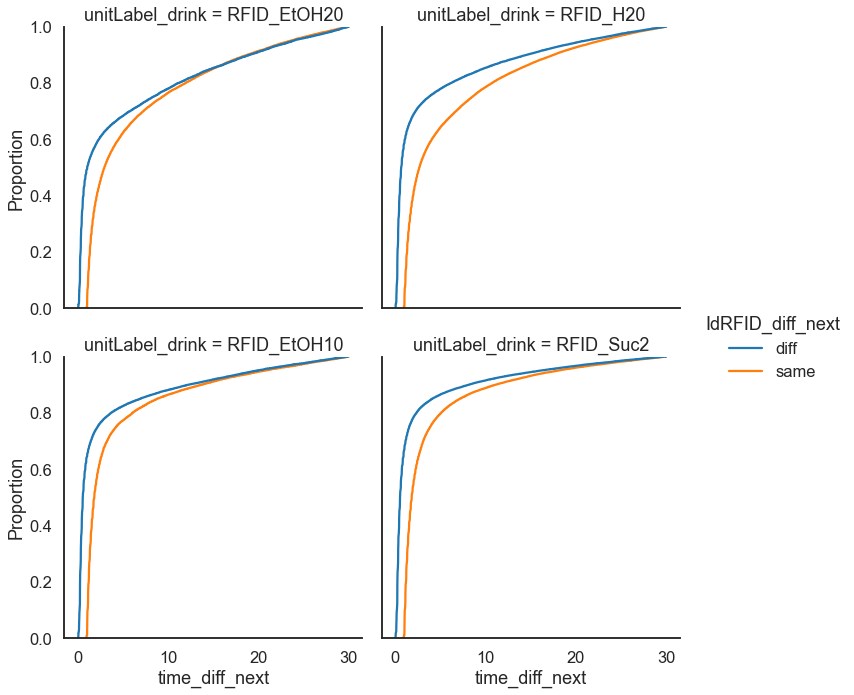

In [17]:
data_int = data_RFID_final[data_RFID_final['time_diff_next'] < 30]
sns.displot(data=data_int, x="time_diff_next", hue="IdRFID_diff_next", kind="ecdf", col="unitLabel_drink", col_wrap=2)
plt.show()

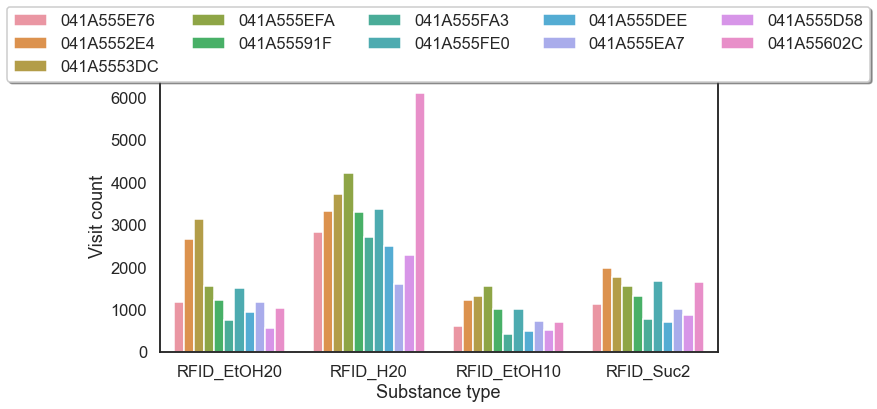

In [18]:
data_int = data_RFID_final[data_RFID_final['RFID_day_count'] < 8]
plt.figure(figsize=(10,5))
sns.countplot(data=data_int, x="unitLabel_drink", hue="IdRFID")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=5, fancybox=True, shadow=True)
plt.xlabel('Substance type')
plt.ylabel('Visit count')
plt.show()

In [19]:
data_RFID_final.groupby(['Cage'])['IdRFID'].unique()

Cage
1    [041A555FA3, 041A555FE0, 041A555DEE]
2    [041A555EFA, 041A55591F]            
3    [041A555E76, 041A5552E4, 041A5553DC]
4    [041A555EA7, 041A555D58, 041A55602C]
Name: IdRFID, dtype: object

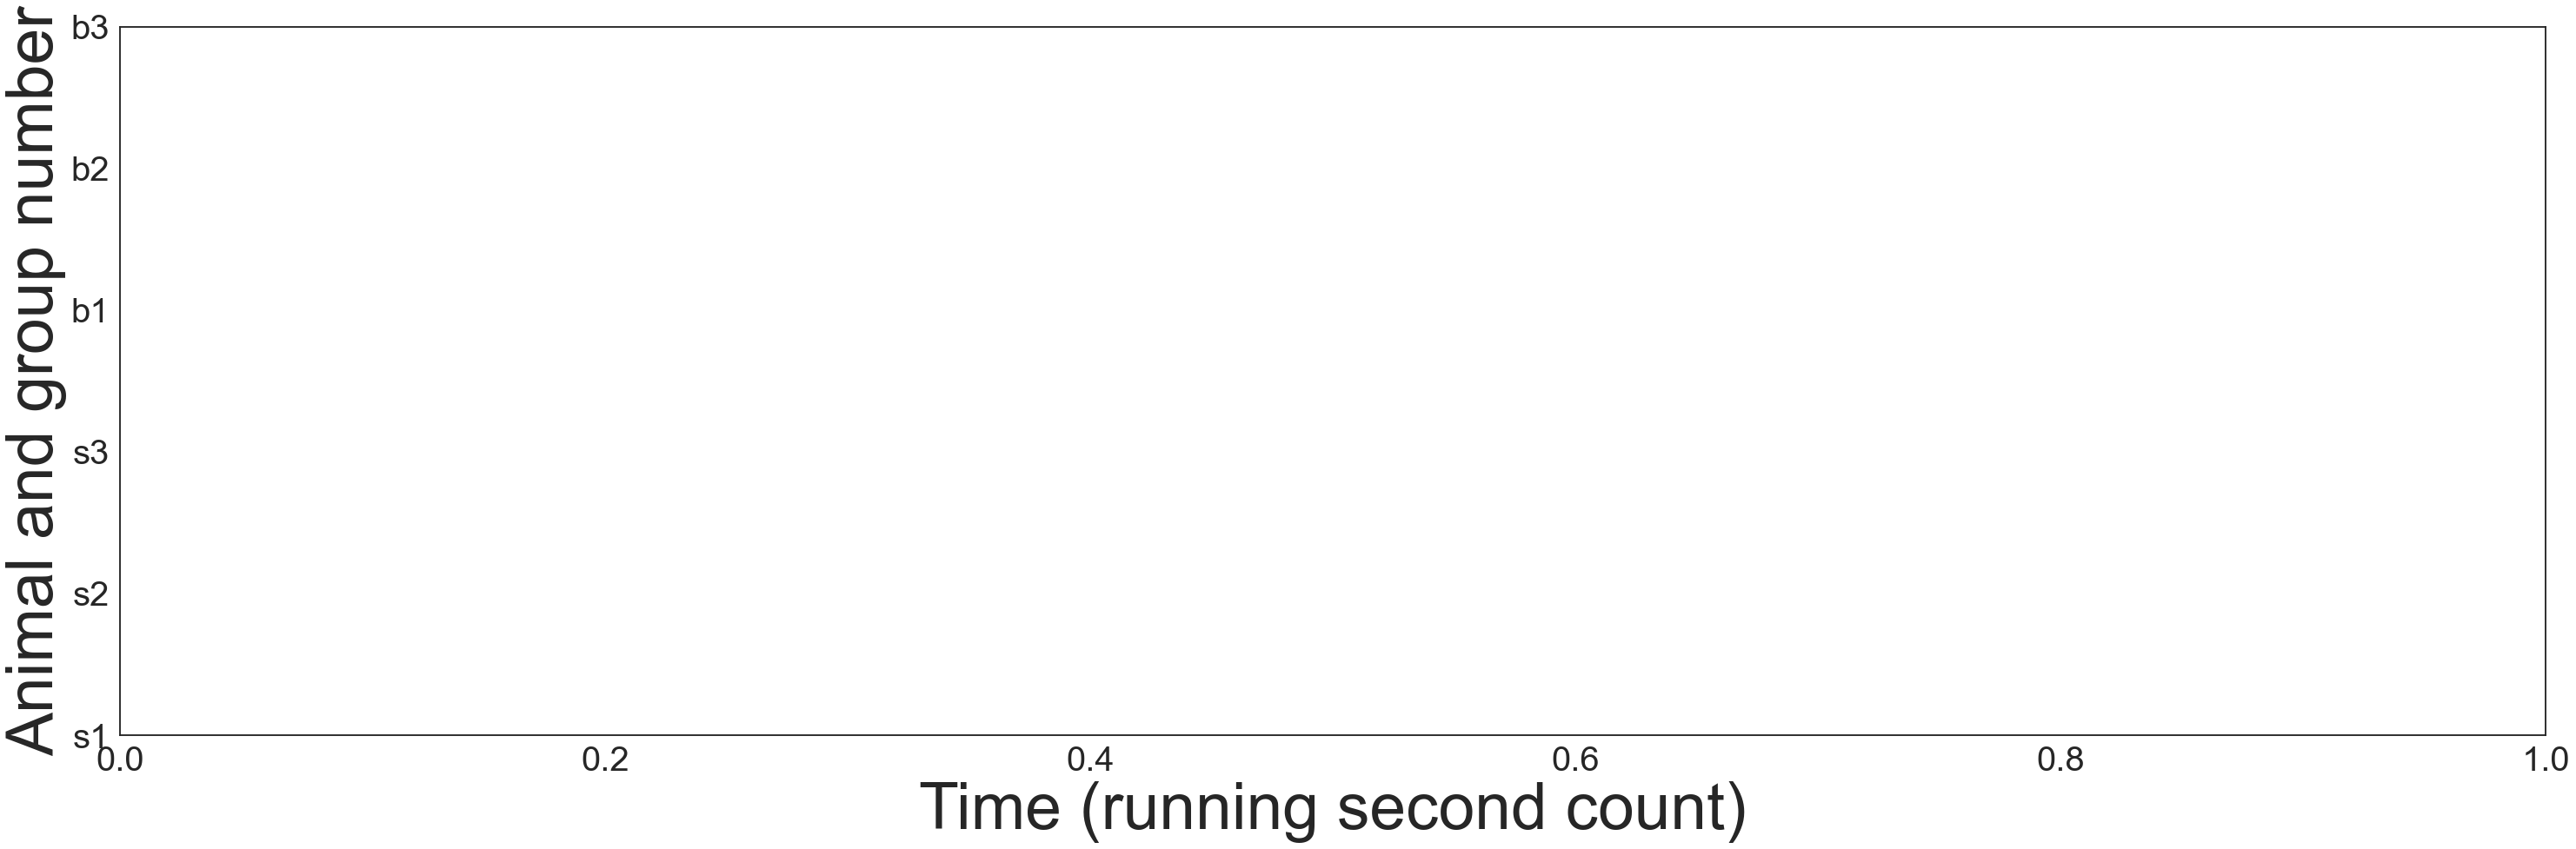

In [20]:
data_ul1 = data_RFID_final[data_RFID_final['RFID_day_count'] ==5]
data_ul12 = data_ul1[data_ul1['RFID_min_count_running'] == 5727]
#data_ul12 = data_ul1
colorCodes = ['C{}'.format(i) for i in range(6)]

data_1 = data_ul12[data_ul12['IdRFID'] == '041A555FA3']['RFID_sec_count'].values
data_2 = data_ul12[data_ul12['IdRFID'] == '041A555FE0']['RFID_sec_count'].values
data_3 = data_ul12[data_ul12['IdRFID'] == '041A555DEE']['RFID_sec_count'].values

data_4 = data_ul12[data_ul12['IdRFID'] == '041A555EA7']['RFID_sec_count'].values
data_5 = data_ul12[data_ul12['IdRFID'] == '041A555D58']['RFID_sec_count'].values
data_6 = data_ul12[data_ul12['IdRFID'] == '041A55602C']['RFID_sec_count'].values

data_array = np.array([data_1, data_2, data_3, data_4, data_5, data_6])

# Draw a spike raster plot
plt.figure(figsize=(50,15))
params = {'axes.labelsize': 75,
          'axes.titlesize': 75}
plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=40) 
plt.rcParams.update(params)
plt.yticks([0,1,2,3,4,5], 
           ['s1', 's2', 's3', 'b1', 'b2', 'b3'])
plt.eventplot(data_array, color=colorCodes, linelengths = 0.3) 
plt.xlabel('Time (running second count)')
plt.ylabel('Animal and group number')


plt.show()

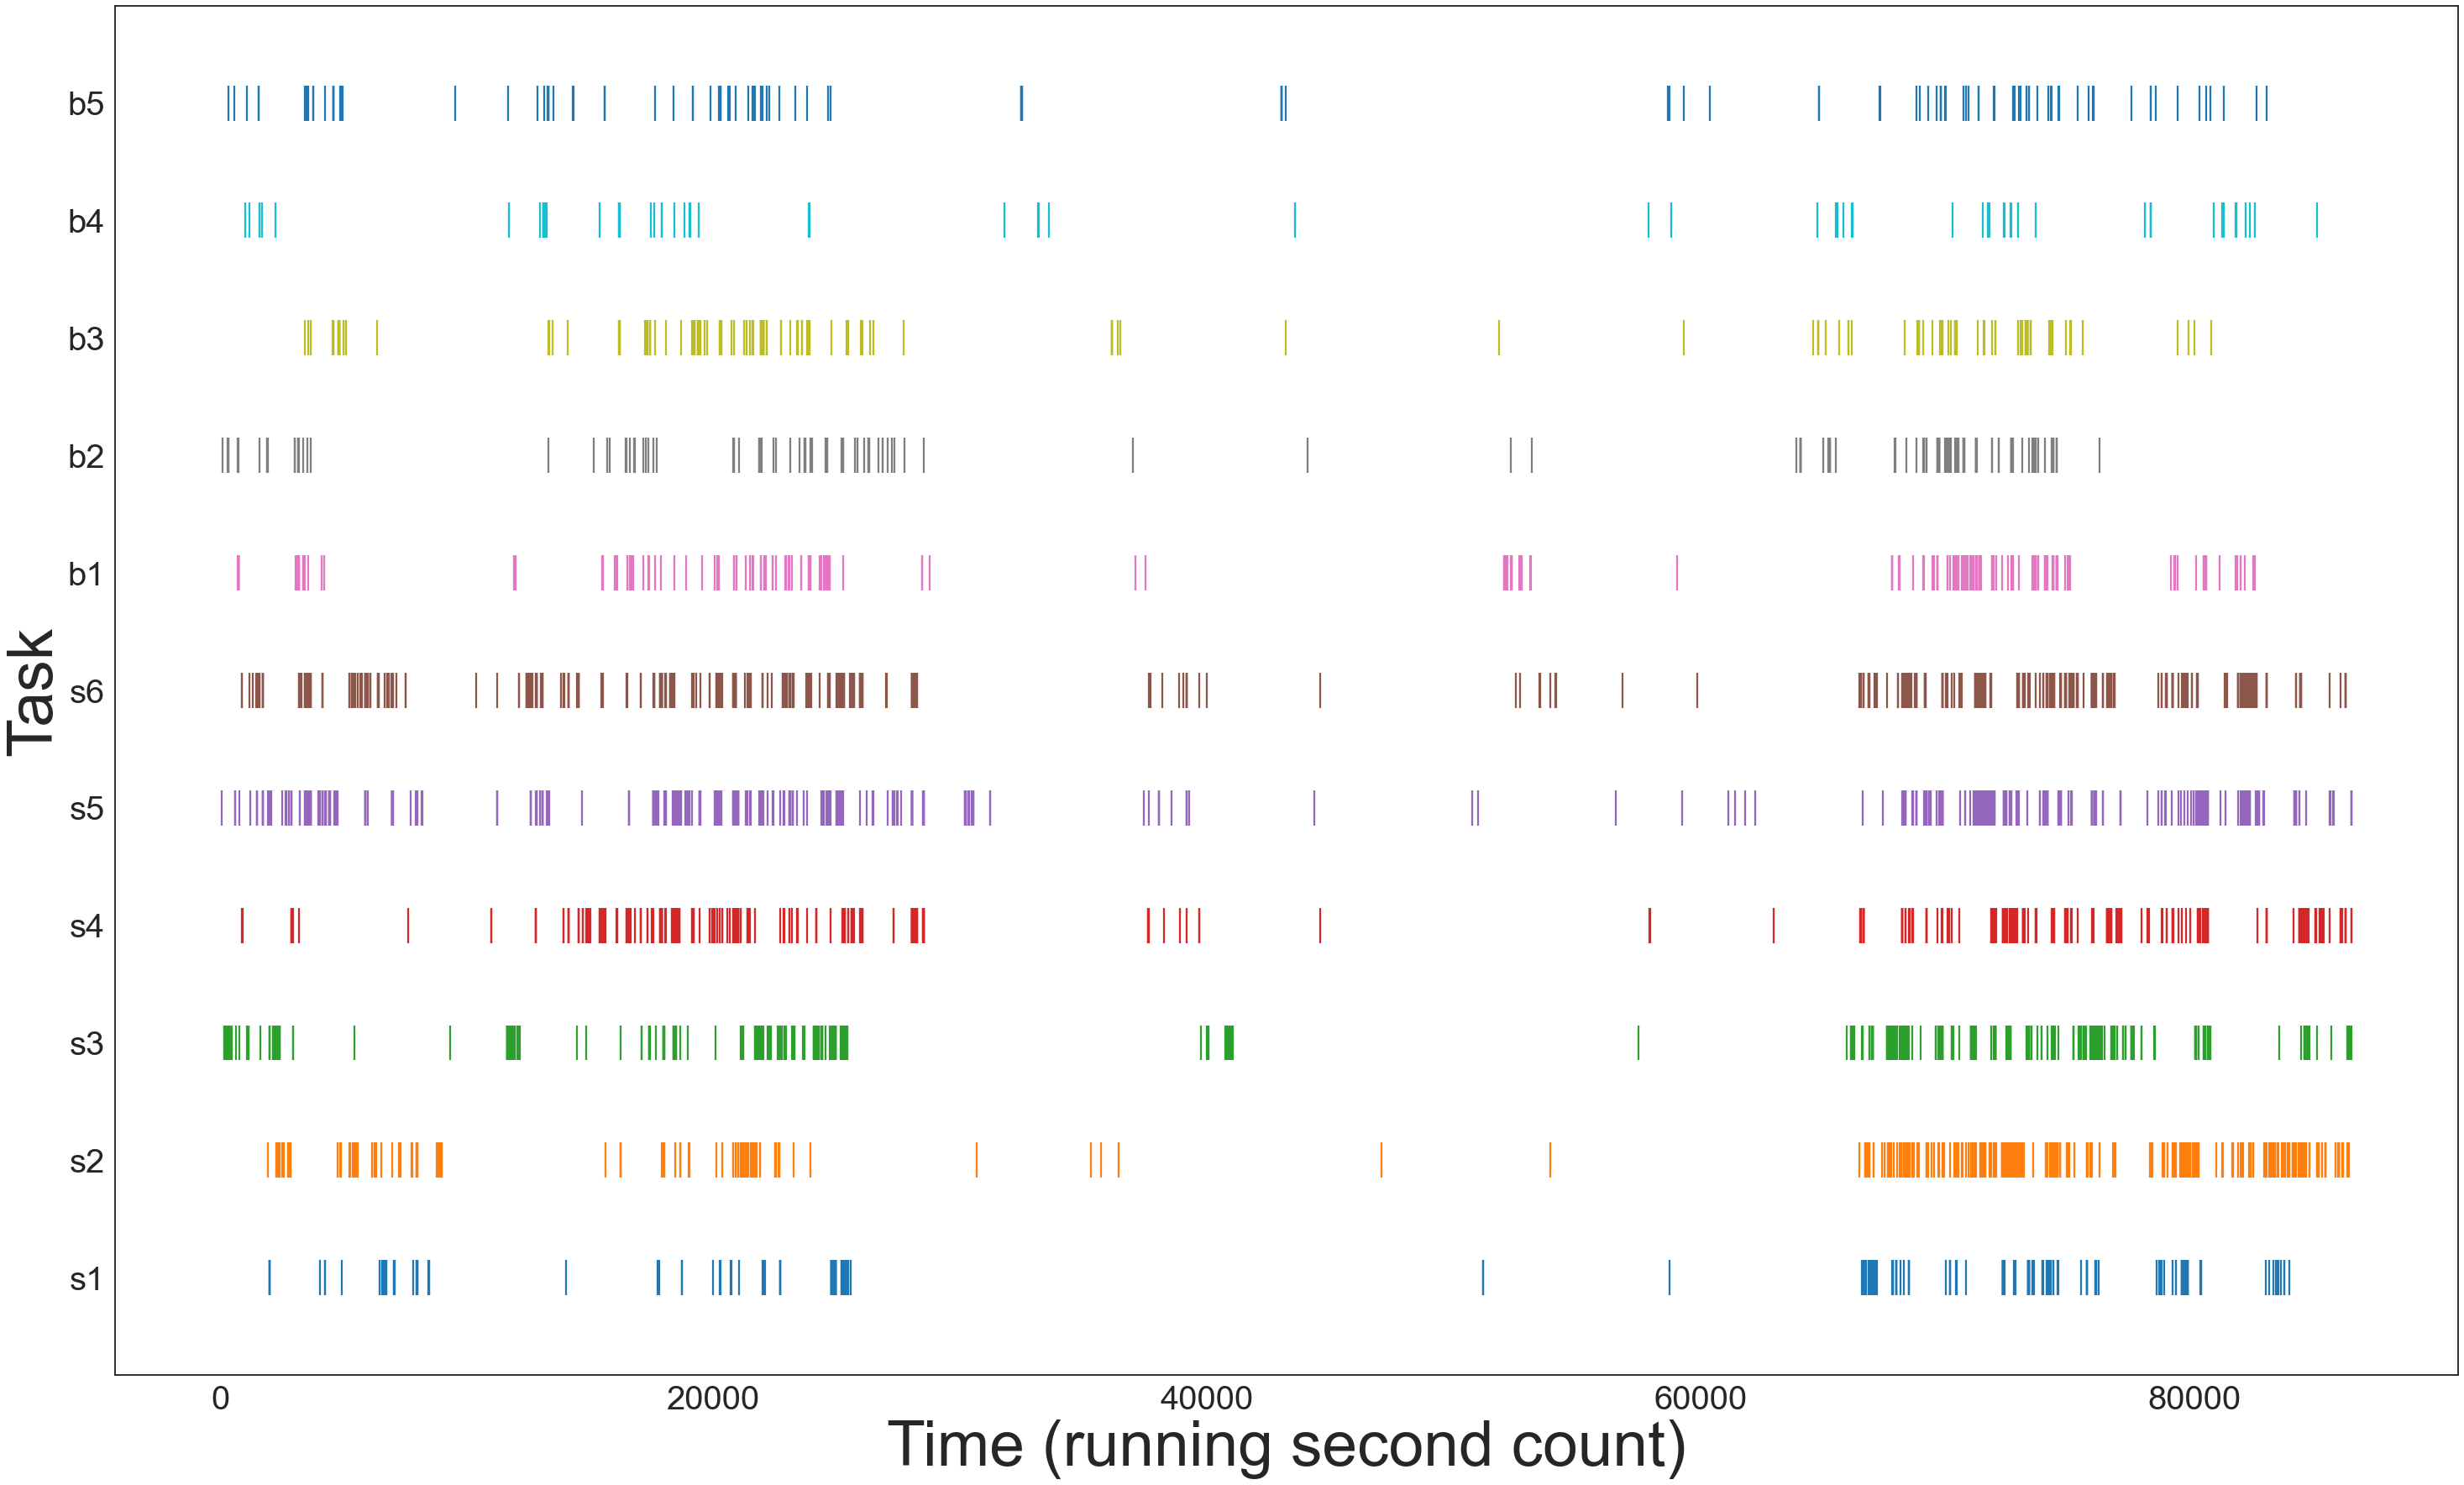

In [21]:
data_ul1 = data_RFID_final[data_RFID_final['unitLabel_drink'] == 'RFID_Suc2']
data_ul12 = data_ul1[data_ul1['RFID_day_count'] == 27]
#data_ul12 = data_ul1
colorCodes = ['C{}'.format(i) for i in range(11)]

data_1 = data_ul12[data_ul12['IdRFID'] == '041A555DEE']['RFID_sec_count'].values
data_2 = data_ul12[data_ul12['IdRFID'] == '041A555FA3']['RFID_sec_count'].values
data_3 = data_ul12[data_ul12['IdRFID'] == '041A555FE0']['RFID_sec_count'].values
data_4 = data_ul12[data_ul12['IdRFID'] == '041A5552E4']['RFID_sec_count'].values
data_5 = data_ul12[data_ul12['IdRFID'] == '041A5553DC']['RFID_sec_count'].values
data_6 = data_ul12[data_ul12['IdRFID'] == '041A555E76']['RFID_sec_count'].values
data_7 = data_ul12[data_ul12['IdRFID'] == '041A55591F']['RFID_sec_count'].values
data_8 = data_ul12[data_ul12['IdRFID'] == '041A555EFA']['RFID_sec_count'].values
data_9 = data_ul12[data_ul12['IdRFID'] == '041A555D58']['RFID_sec_count'].values
data_10 = data_ul12[data_ul12['IdRFID'] == '041A555EA7']['RFID_sec_count'].values
data_11 = data_ul12[data_ul12['IdRFID'] == '041A55602C']['RFID_sec_count'].values

data_array = np.array([data_1, data_2, data_3, data_4, data_5,
                      data_6, data_7, data_8, data_9, data_10,
                      data_11,])

# Draw a spike raster plot
plt.figure(figsize=(50,30))
params = {'axes.labelsize': 75,
          'axes.titlesize': 75}
plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=40) 
plt.rcParams.update(params)
plt.yticks([0,1,2,3,4,5,6,7,8,9,10], 
           ['s1', 's2', 's3',
            's4', 's5', 's6', 
            'b1', 'b2', 'b3', 'b4', 
            'b5'])
plt.eventplot(data_array, color=colorCodes, linelengths = 0.3) 
plt.xlabel('Time (running second count)')
plt.ylabel('Task')


plt.show()

### VDM data

#### Make and clean df

In [22]:
#create list of dir paths
VDM_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r2.1m'
    
VDM_file_names = os.listdir(VDM_path)

VDM_data_dir_paths = []

for file in VDM_file_names:
    int_path = VDM_path + '/' + file
    VDM_data_dir_paths.append(int_path)
    
VDM_data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r2.1m/210319.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r2.1m/210402.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r2.1m/210407.csv']

In [23]:
data_VDM = pd.DataFrame()

for path in VDM_data_dir_paths:
    print(path)
    
    if path.split('/')[-1] == '.DS_Store':
        continue
        
    #create data table
    data_VDM_int = pd.read_table(path, sep=';')
    data_VDM_int = pd.DataFrame(data = data_VDM_int)
    data_VDM_int = data_VDM_int.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])['Columbus Instruments Device Interface Version 1.5'].str.split(',', expand=True)
    data_VDM_int.columns = data_VDM_int.loc[18].values
    data_VDM_int = data_VDM_int.drop([18])
    
    data_VDM_int['Cohort'] = path.split('/')[-2].split('.')[0]
    data_VDM_int['TP'] = path.split('/')[-2].split('.')[1]
    data_VDM_int['StartDate'] = path.split('/')[-1].split('.')[0]

    if data_VDM.empty:
        data_VDM = data_VDM_int
    else:
        data_VDM = pd.concat([data_VDM, data_VDM_int], axis=0)
        
    print(data_VDM.shape,'\n')

print(data_VDM.shape)
data_VDM.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r2.1m/210319.csv
(3020779, 15) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r2.1m/210402.csv
(4125732, 15) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r2.1m/210407.csv
(5861716, 15) 

(5861716, 15)


,Int,Cage,Time,Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),,Cohort,TP,StartDate
19,0,1,03/19/21 14:06:50,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,r2,1m,210319
20,0,2,03/19/21 14:06:50,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,r2,1m,210319
21,0,3,03/19/21 14:06:50,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,r2,1m,210319
22,0,4,03/19/21 14:06:50,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,r2,1m,210319
23,1,1,03/19/21 14:06:51,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,r2,1m,210319


#### Clean up column names

In [24]:
data_VDM.columns = ['Int', 'Cage_VDM', 'VDM_Time', 
                    'VDM_EtOH10', 'VDM_EtOH10_accum',
                    'VDM_Suc2', 'VDM_Suc2_accum', 
                    'VDM_EtOH20', 'VDM_EtOH20_accum', 
                    'VDM_H20', 'VDM_H20_accum', '',
                    'Cohort', 'TP', 'StartDate']

data_VDM = data_VDM[['Cage_VDM', 'Cohort', 'TP', 'StartDate', 'VDM_Time', 'VDM_EtOH10', 'VDM_EtOH20', 'VDM_Suc2', 'VDM_H20']]

data_VDM.tail()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,VDM_EtOH10,VDM_EtOH20,VDM_Suc2,VDM_H20
1735998,4,r2,1m,210407,04/15/21 15:41:18,0.000,0.000,0.000,0.000
1735999,1,r2,1m,210407,04/15/21 15:41:20,0.000,0.000,0.000,0.000
1736000,2,r2,1m,210407,04/15/21 15:41:20,0.000,0.000,0.000,0.000
1736001,3,r2,1m,210407,04/15/21 15:41:20,0.000,0.000,0.000,0.000
1736002,4,r2,1m,210407,04/15/21 15:41:20,0.000,0.000,0.000,0.000


#### Convert liquid vol to etoh vol

In [25]:
data_VDM['VDM_EtOH10'] = data_VDM['VDM_EtOH10'].astype('float')
data_VDM['VDM_EtOH20'] = data_VDM['VDM_EtOH20'].astype('float')
data_VDM['VDM_Suc2'] = data_VDM['VDM_Suc2'].astype('float')
data_VDM['VDM_H20'] = data_VDM['VDM_H20'].astype('float')

#### Make into tidy df

In [26]:
#melt dataframe (new column of parameters)

meta_params = ['Cage_VDM', 'Cohort', 'TP', 'StartDate', 'VDM_Time']
intake_params = ['VDM_EtOH10', 'VDM_EtOH20', 'VDM_Suc2', 'VDM_H20']

data_VDM_tidy = pd.melt(data_VDM, id_vars=meta_params, value_vars=intake_params)

print(data_VDM_tidy.shape)
data_VDM_tidy.head()

(23446864, 7)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value
0,1,r2,1m,210319,03/19/21 14:06:50,VDM_EtOH10,0.0
1,2,r2,1m,210319,03/19/21 14:06:50,VDM_EtOH10,0.0
2,3,r2,1m,210319,03/19/21 14:06:50,VDM_EtOH10,0.0
3,4,r2,1m,210319,03/19/21 14:06:50,VDM_EtOH10,0.0
4,1,r2,1m,210319,03/19/21 14:06:51,VDM_EtOH10,0.0


#### Drop times with no intake data

In [27]:
data_VDM_tidy_intake = data_VDM_tidy[data_VDM_tidy['value'] > 0]
print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(95805, 7)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value
29991,1,r2,1m,210319,03/19/21 17:26:26,VDM_EtOH10,0.022
40354,4,r2,1m,210319,03/19/21 18:35:09,VDM_EtOH10,0.021
57266,4,r2,1m,210319,03/19/21 20:27:20,VDM_EtOH10,0.021
81490,4,r2,1m,210319,03/19/21 23:08:01,VDM_EtOH10,0.021
83675,1,r2,1m,210319,03/19/21 23:22:32,VDM_EtOH10,0.022


#### Clean up datetime

In [28]:
#clean up and create datetime columns
data_VDM_tidy_intake['VDM_datetime'] = pd.to_datetime(data_VDM_tidy_intake['VDM_Time'])
data_VDM_tidy_intake['VDM_timestamp'] = [x.timestamp() for x in data_VDM_tidy_intake['VDM_datetime']]

data_VDM_tidy_intake['VDM_date'] = data_VDM_tidy_intake['VDM_datetime'].dt.date
data_VDM_tidy_intake['VDM_day'] = data_VDM_tidy_intake['VDM_datetime'].dt.day
data_VDM_tidy_intake['VDM_time'] = data_VDM_tidy_intake['VDM_datetime'].dt.strftime("%H:%M:%S")
data_VDM_tidy_intake['VDM_hour'] = data_VDM_tidy_intake['VDM_datetime'].dt.hour
data_VDM_tidy_intake['VDM_min'] = data_VDM_tidy_intake['VDM_datetime'].dt.minute
data_VDM_tidy_intake['VDM_second'] = data_VDM_tidy_intake['VDM_datetime'].dt.second

print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(95805, 15)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second
29991,1,r2,1m,210319,03/19/21 17:26:26,VDM_EtOH10,0.022,2021-03-19 17:26:26,1.616175e+09,2021-03-19,19,17:26:26,17,26,26
40354,4,r2,1m,210319,03/19/21 18:35:09,VDM_EtOH10,0.021,2021-03-19 18:35:09,1.616179e+09,2021-03-19,19,18:35:09,18,35,9
57266,4,r2,1m,210319,03/19/21 20:27:20,VDM_EtOH10,0.021,2021-03-19 20:27:20,1.616186e+09,2021-03-19,19,20:27:20,20,27,20
81490,4,r2,1m,210319,03/19/21 23:08:01,VDM_EtOH10,0.021,2021-03-19 23:08:01,1.616195e+09,2021-03-19,19,23:08:01,23,8,1
83675,1,r2,1m,210319,03/19/21 23:22:32,VDM_EtOH10,0.022,2021-03-19 23:22:32,1.616196e+09,2021-03-19,19,23:22:32,23,22,32


#### Add light dark and clean

In [29]:
def assign_ld(time):
    if (time >= 6) & (time < 18):
        return 'light'
    if (time >= 0) & (time < 6):
        return 'dark_am'
    if (time >= 18):
        return 'dark_pm'
    
data_VDM_tidy_intake['ld_seg'] = data_VDM_tidy_intake['VDM_hour'].apply(assign_ld)

data_VDM_tidy_intake.head()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg
29991,1,r2,1m,210319,03/19/21 17:26:26,VDM_EtOH10,0.022,2021-03-19 17:26:26,1.616175e+09,2021-03-19,19,17:26:26,17,26,26,light
40354,4,r2,1m,210319,03/19/21 18:35:09,VDM_EtOH10,0.021,2021-03-19 18:35:09,1.616179e+09,2021-03-19,19,18:35:09,18,35,9,dark_pm
57266,4,r2,1m,210319,03/19/21 20:27:20,VDM_EtOH10,0.021,2021-03-19 20:27:20,1.616186e+09,2021-03-19,19,20:27:20,20,27,20,dark_pm
81490,4,r2,1m,210319,03/19/21 23:08:01,VDM_EtOH10,0.021,2021-03-19 23:08:01,1.616195e+09,2021-03-19,19,23:08:01,23,8,1,dark_pm
83675,1,r2,1m,210319,03/19/21 23:22:32,VDM_EtOH10,0.022,2021-03-19 23:22:32,1.616196e+09,2021-03-19,19,23:22:32,23,22,32,dark_pm


### Filter RFID data by VDM times

In [30]:
data_VDM_tidy_intake = data_VDM_tidy_intake.sort_values(['variable', 'VDM_datetime']).reset_index(drop=True)
data_VDM_tidy_intake.head()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg
0,1,r2,1m,210319,03/19/21 17:26:26,VDM_EtOH10,0.022,2021-03-19 17:26:26,1.616175e+09,2021-03-19,19,17:26:26,17,26,26,light
1,4,r2,1m,210319,03/19/21 18:35:09,VDM_EtOH10,0.021,2021-03-19 18:35:09,1.616179e+09,2021-03-19,19,18:35:09,18,35,9,dark_pm
2,4,r2,1m,210319,03/19/21 20:27:20,VDM_EtOH10,0.021,2021-03-19 20:27:20,1.616186e+09,2021-03-19,19,20:27:20,20,27,20,dark_pm
3,4,r2,1m,210319,03/19/21 23:08:01,VDM_EtOH10,0.021,2021-03-19 23:08:01,1.616195e+09,2021-03-19,19,23:08:01,23,8,1,dark_pm
4,1,r2,1m,210319,03/19/21 23:22:32,VDM_EtOH10,0.022,2021-03-19 23:22:32,1.616196e+09,2021-03-19,19,23:22:32,23,22,32,dark_pm


In [31]:
data_RFID_final= data_RFID_final.sort_values(['unitLabel_drink', 'RFID_datetime_start']).reset_index(drop=True)
data_RFID_final.head()

,Round,Round_info,Timepoint,Cage_N,Cage,Animal,Injury,IdRFID,weight_pre,weight_post,weight_diff,notes,wd_day,r_day,unitLabel,unitLabel_drink,eventDuration,RFID_datetime_start,RFID_datetime_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_time_start,RFID_time_end,RFID_date,RFID_day,ld,ld_seg,RFID_day_count,RFID_hour,RFID_min,RFID_second,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running
0,sucrose1,post-PET,1,3,1,1201,sham,041A555FE0,32.5,34.8,1.070769,NaN,15.0,20.0,AM1-1,RFID_EtOH10,4.004,2021-03-19 14:05:29.735030400,2021-03-19 14:05:33.739030400,2021-03-19 14:06:53.151984000,041A555FE0,same,79.412953,80.0,14:05:29,14:05:33,2021-03-19,19,light_day1,light,1,14,5,29,845,50729,14,845,50669
1,sucrose1,post-PET,1,3,1,1201,sham,041A555FE0,32.5,34.8,1.070769,NaN,15.0,20.0,AM1-1,RFID_EtOH10,2.675,2021-03-19 14:06:53.151984000,2021-03-19 14:06:55.826984000,2021-03-19 14:07:15.141043200,041A555FE0,same,19.314059,20.0,14:06:53,14:06:55,2021-03-19,19,light_day1,light,1,14,6,53,846,50813,14,846,50753
2,sucrose1,post-PET,1,3,1,1201,sham,041A555FE0,32.5,34.8,1.070769,NaN,15.0,20.0,AM1-1,RFID_EtOH10,0.075,2021-03-19 14:07:15.141043200,2021-03-19 14:07:15.216043200,2021-03-19 14:07:56.455017600,041A555FE0,same,41.238974,40.0,14:07:15,14:07:15,2021-03-19,19,light_day1,light,1,14,7,15,847,50835,14,847,50775
3,sucrose1,post-PET,1,3,1,1201,sham,041A555FE0,32.5,34.8,1.070769,NaN,15.0,20.0,AM1-1,RFID_EtOH10,0.229,2021-03-19 14:07:56.455017600,2021-03-19 14:07:56.684017600,2021-03-19 14:09:21.595996800,041A555FE0,same,84.911979,80.0,14:07:56,14:07:56,2021-03-19,19,light_day1,light,1,14,7,56,847,50876,14,847,50816
4,sucrose1,post-PET,1,3,1,1201,sham,041A555FE0,32.5,34.8,1.070769,NaN,15.0,20.0,AM1-1,RFID_EtOH10,6.295,2021-03-19 14:09:21.595996800,2021-03-19 14:09:27.890996800,2021-03-19 14:09:47.118988799,041A555FA3,diff,19.227991,20.0,14:09:21,14:09:27,2021-03-19,19,light_day1,light,1,14,9,21,849,50961,14,849,50901


In [32]:
data_comb = data_VDM_tidy_intake
RFID_data = data_RFID_final

VDM_RFID_mapping = {'VDM_EtOH10': 'RFID_EtOH10',
                    'VDM_Suc2': 'RFID_Suc2',
                    'VDM_EtOH20': 'RFID_EtOH20',
                    'VDM_H20': 'RFID_H20'}

RFID_eventDuration = []
RFID_assign_id_pre = []
RFID_assign_var_pre = []
RFID_datetime_start_pre = []
RFID_datetime_end_pre = []
RFID_datetime_start_next = []
IdRFID_next = []
IdRFID_diff_next = []
time_diff_next = []
ld = []

for index, row in data_comb.iterrows():
    if index%1000 == 0:
        print(index)
    #find RFID signal start time closest to VDM time before
    try:
        int_assign = RFID_data[(RFID_data['Cage'] == int(row['Cage_VDM'])) & #match cage
                               (RFID_data['unitLabel_drink'] == VDM_RFID_mapping[row['variable']]) & #match tube
                               (RFID_data['RFID_datetime_start'] <= row['VDM_datetime']) #find closest datetime
                              ].sort_values(['RFID_datetime_start']).iloc[-1]

        RFID_eventDuration.append(int_assign['eventDuration'])
        RFID_assign_id_pre.append(int_assign['IdRFID'])
        RFID_assign_var_pre.append(int_assign['unitLabel'])
        RFID_datetime_start_pre.append(int_assign['RFID_datetime_start'])
        RFID_datetime_end_pre.append(int_assign['RFID_datetime_end'])
        RFID_datetime_start_next.append(int_assign['RFID_datetime_start_next'])
        IdRFID_next.append(int_assign['IdRFID_next'])
        IdRFID_diff_next.append(int_assign['IdRFID_diff_next'])
        time_diff_next.append(int_assign['time_diff_next'])
        ld.append(int_assign['ld'])
        
    except:
        print(index, 'pre')
        RFID_eventDuration.append(np.nan)
        RFID_assign_id_pre.append(np.nan)
        RFID_assign_var_pre.append(np.nan)
        RFID_datetime_start_pre.append(np.nan)
        RFID_datetime_end_pre.append(np.nan)
        RFID_datetime_start_next.append(np.nan)
        IdRFID_next.append(np.nan)
        IdRFID_diff_next.append(np.nan)
        time_diff_next.append(np.nan)
        ld.append(np.nan)
        
data_comb['RFID_eventDuration'] = RFID_eventDuration
data_comb['RFID_assign_id_pre'] = RFID_assign_id_pre
data_comb['RFID_assign_var_pre'] = RFID_assign_var_pre
data_comb['RFID_datetime_start_pre'] = RFID_datetime_start_pre
data_comb['RFID_datetime_end_pre'] = RFID_datetime_end_pre
data_comb['RFID_datetime_start_next'] = RFID_datetime_start_next
data_comb['IdRFID_next'] = IdRFID_next
data_comb['IdRFID_diff_next'] = IdRFID_diff_next
data_comb['time_diff_next'] = time_diff_next
data_comb['ld'] = ld

print(data_comb.shape)
data_comb.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
(95805, 26)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,ld
0,1,r2,1m,210319,03/19/21 17:26:26,VDM_EtOH10,0.022,2021-03-19 17:26:26,1.616175e+09,2021-03-19,19,17:26:26,17,26,26,light,0.214,041A555FE0,AM1-1,2021-03-19 17:04:20.908012800,2021-03-19 17:04:21.122012800,2021-03-19 17:40:08.793955200,041A555FE0,same,2147.671942,light_day1
1,4,r2,1m,210319,03/19/21 18:35:09,VDM_EtOH10,0.021,2021-03-19 18:35:09,1.616179e+09,2021-03-19,19,18:35:09,18,35,9,dark_pm,1.415,041A555D58,AM1-13,2021-03-19 18:30:56.671977600,2021-03-19 18:30:58.086977600,2021-03-19 18:36:24.477983999,041A555EA7,diff,326.391006,dark_night1
2,4,r2,1m,210319,03/19/21 20:27:20,VDM_EtOH10,0.021,2021-03-19 20:27:20,1.616186e+09,2021-03-19,19,20:27:20,20,27,20,dark_pm,0.229,041A555D58,AM1-13,2021-03-19 20:12:08.802979200,2021-03-19 20:12:09.031979200,2021-03-19 20:27:53.624995200,041A555D58,same,944.593016,dark_night1
3,4,r2,1m,210319,03/19/21 23:08:01,VDM_EtOH10,0.021,2021-03-19 23:08:01,1.616195e+09,2021-03-19,19,23:08:01,23,8,1,dark_pm,1.303,041A555EA7,AM1-13,2021-03-19 23:03:22.302979200,2021-03-19 23:03:23.605979200,2021-03-19 23:08:54.712032000,041A555D58,diff,331.106052,dark_night1
4,1,r2,1m,210319,03/19/21 23:22:32,VDM_EtOH10,0.022,2021-03-19 23:22:32,1.616196e+09,2021-03-19,19,23:22:32,23,22,32,dark_pm,1.675,041A555DEE,AM1-1,2021-03-19 23:21:57.582000000,2021-03-19 23:21:59.257000000,2021-03-19 23:22:43.400006400,041A555DEE,same,44.143006,dark_night1


In [33]:
def time_within(RFID_start, RFID_stop, VDM_time):
    
    if (VDM_time >= RFID_start) & (VDM_time <= RFID_stop):
        return 0
    
    elif (VDM_time >= RFID_start) & (VDM_time >= RFID_stop):
        time_within = VDM_time - RFID_stop
        time_within = time_within.total_seconds()
        return time_within
    
data_comb['VDM_RFID_timediff'] = data_comb.apply(lambda row: time_within(row['RFID_datetime_start_pre'], 
                                                                   row['RFID_datetime_end_pre'],
                                                                   row['VDM_datetime']), axis=1)

data_comb.head()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,ld,VDM_RFID_timediff
0,1,r2,1m,210319,03/19/21 17:26:26,VDM_EtOH10,0.022,2021-03-19 17:26:26,1.616175e+09,2021-03-19,19,17:26:26,17,26,26,light,0.214,041A555FE0,AM1-1,2021-03-19 17:04:20.908012800,2021-03-19 17:04:21.122012800,2021-03-19 17:40:08.793955200,041A555FE0,same,2147.671942,light_day1,1324.877987
1,4,r2,1m,210319,03/19/21 18:35:09,VDM_EtOH10,0.021,2021-03-19 18:35:09,1.616179e+09,2021-03-19,19,18:35:09,18,35,9,dark_pm,1.415,041A555D58,AM1-13,2021-03-19 18:30:56.671977600,2021-03-19 18:30:58.086977600,2021-03-19 18:36:24.477983999,041A555EA7,diff,326.391006,dark_night1,250.913022
2,4,r2,1m,210319,03/19/21 20:27:20,VDM_EtOH10,0.021,2021-03-19 20:27:20,1.616186e+09,2021-03-19,19,20:27:20,20,27,20,dark_pm,0.229,041A555D58,AM1-13,2021-03-19 20:12:08.802979200,2021-03-19 20:12:09.031979200,2021-03-19 20:27:53.624995200,041A555D58,same,944.593016,dark_night1,910.968020
3,4,r2,1m,210319,03/19/21 23:08:01,VDM_EtOH10,0.021,2021-03-19 23:08:01,1.616195e+09,2021-03-19,19,23:08:01,23,8,1,dark_pm,1.303,041A555EA7,AM1-13,2021-03-19 23:03:22.302979200,2021-03-19 23:03:23.605979200,2021-03-19 23:08:54.712032000,041A555D58,diff,331.106052,dark_night1,277.394020
4,1,r2,1m,210319,03/19/21 23:22:32,VDM_EtOH10,0.022,2021-03-19 23:22:32,1.616196e+09,2021-03-19,19,23:22:32,23,22,32,dark_pm,1.675,041A555DEE,AM1-1,2021-03-19 23:21:57.582000000,2021-03-19 23:21:59.257000000,2021-03-19 23:22:43.400006400,041A555DEE,same,44.143006,dark_night1,32.743000


#### Add metadata

In [34]:
data_comb = meta_data.merge(data_comb.reset_index(), left_on='IdRFID', right_on='RFID_assign_id_pre', sort=False)

print(data_comb.shape)
data_comb.head()

(95805, 42)


,Round,Round_info,Timepoint,Cage_N,Cage,Animal,Injury,IdRFID,weight_pre,weight_post,weight_diff,notes,wd_day,r_day,index,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,ld,VDM_RFID_timediff
0,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,7,3,r2,1m,210319,03/20/21 04:32:44,VDM_EtOH10,0.021,2021-03-20 04:32:44,1.616215e+09,2021-03-20,20,04:32:44,4,32,44,dark_am,5.219,041A555E76,AM1-9,2021-03-20 03:10:09.341961600,2021-03-20 03:10:14.560961600,2021-03-20 05:18:17.624016000,041A555E76,same,7683.063054,dark_night1,4949.439038
1,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,37,3,r2,1m,210319,03/21/21 11:38:45,VDM_EtOH10,0.021,2021-03-21 11:38:45,1.616327e+09,2021-03-21,21,11:38:45,11,38,45,light,3.462,041A555E76,AM1-9,2021-03-21 09:31:32.006985600,2021-03-21 09:31:35.468985600,2021-03-21 11:56:48.500966400,041A5553DC,diff,8713.031980,light_day3,7629.531014
2,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,41,3,r2,1m,210319,03/21/21 16:09:28,VDM_EtOH10,0.021,2021-03-21 16:09:28,1.616343e+09,2021-03-21,21,16:09:28,16,9,28,light,3.534,041A555E76,AM1-9,2021-03-21 13:00:09.809020800,2021-03-21 13:00:13.343020800,2021-03-21 17:28:17.923008000,041A5553DC,diff,16084.579987,light_day3,11354.656979
3,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,58,3,r2,1m,210319,03/22/21 10:23:52,VDM_EtOH10,0.021,2021-03-22 10:23:52,1.616409e+09,2021-03-22,22,10:23:52,10,23,52,light,0.958,041A555E76,AM1-9,2021-03-22 09:08:42.986976000,2021-03-22 09:08:43.944976000,2021-03-22 13:19:56.645990400,041A5553DC,diff,15072.701014,light_day4,4508.055024
4,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,98,3,r2,1m,210319,03/24/21 03:25:55,VDM_EtOH10,0.021,2021-03-24 03:25:55,1.616556e+09,2021-03-24,24,03:25:55,3,25,55,dark_am,4.630,041A555E76,AM1-9,2021-03-24 03:18:41.775004800,2021-03-24 03:18:46.405004800,2021-03-24 03:39:23.567990399,041A5552E4,diff,1237.162985,dark_night5,428.594995


#### Add day, hour, and min counts

In [35]:
#column of running day count
dat_map = dict(zip(data_comb['VDM_date'].unique(), np.arange(1,len(data_comb['VDM_date'].unique())+1)))
data_comb['VDM_day_count'] = data_comb['VDM_date'].map(dat_map)

#column of running min and second count within each day
data_comb['VDM_min_count'] = (data_comb['VDM_hour']*60) + data_comb['VDM_min'] 
data_comb['VDM_second_count'] = (data_comb['VDM_min_count']*60) + data_comb['VDM_second'] 

#column of running hour and minute count
data_comb['VDM_hour_count_running'] = (data_comb['VDM_day_count']*24) + data_comb['VDM_hour'] - 24
data_comb['VDM_min_count_running'] = (data_comb['VDM_hour_count_running']*60) + data_comb['VDM_min'] 
data_comb['VDM_second_count_running'] = (data_comb['VDM_min_count_running']*60) + data_comb['VDM_second'] - 60

print(data_comb.shape)
data_comb.head()

(95805, 48)


,Round,Round_info,Timepoint,Cage_N,Cage,Animal,Injury,IdRFID,weight_pre,weight_post,weight_diff,notes,wd_day,r_day,index,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,ld,VDM_RFID_timediff,VDM_day_count,VDM_min_count,VDM_second_count,VDM_hour_count_running,VDM_min_count_running,VDM_second_count_running
0,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,7,3,r2,1m,210319,03/20/21 04:32:44,VDM_EtOH10,0.021,2021-03-20 04:32:44,1.616215e+09,2021-03-20,20,04:32:44,4,32,44,dark_am,5.219,041A555E76,AM1-9,2021-03-20 03:10:09.341961600,2021-03-20 03:10:14.560961600,2021-03-20 05:18:17.624016000,041A555E76,same,7683.063054,dark_night1,4949.439038,1,272,16364,4,272,16304
1,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,37,3,r2,1m,210319,03/21/21 11:38:45,VDM_EtOH10,0.021,2021-03-21 11:38:45,1.616327e+09,2021-03-21,21,11:38:45,11,38,45,light,3.462,041A555E76,AM1-9,2021-03-21 09:31:32.006985600,2021-03-21 09:31:35.468985600,2021-03-21 11:56:48.500966400,041A5553DC,diff,8713.031980,light_day3,7629.531014,2,698,41925,35,2138,128265
2,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,41,3,r2,1m,210319,03/21/21 16:09:28,VDM_EtOH10,0.021,2021-03-21 16:09:28,1.616343e+09,2021-03-21,21,16:09:28,16,9,28,light,3.534,041A555E76,AM1-9,2021-03-21 13:00:09.809020800,2021-03-21 13:00:13.343020800,2021-03-21 17:28:17.923008000,041A5553DC,diff,16084.579987,light_day3,11354.656979,2,969,58168,40,2409,144508
3,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,58,3,r2,1m,210319,03/22/21 10:23:52,VDM_EtOH10,0.021,2021-03-22 10:23:52,1.616409e+09,2021-03-22,22,10:23:52,10,23,52,light,0.958,041A555E76,AM1-9,2021-03-22 09:08:42.986976000,2021-03-22 09:08:43.944976000,2021-03-22 13:19:56.645990400,041A5553DC,diff,15072.701014,light_day4,4508.055024,3,623,37432,58,3503,210172
4,sucrose1,post-PET,1,3,3,1188,sham,041A555E76,32.5,34.9,1.073846,NaN,15.0,20.0,98,3,r2,1m,210319,03/24/21 03:25:55,VDM_EtOH10,0.021,2021-03-24 03:25:55,1.616556e+09,2021-03-24,24,03:25:55,3,25,55,dark_am,4.630,041A555E76,AM1-9,2021-03-24 03:18:41.775004800,2021-03-24 03:18:46.405004800,2021-03-24 03:39:23.567990399,041A5552E4,diff,1237.162985,dark_night5,428.594995,4,205,12355,75,4525,271495


#### Viz

<Figure size 720x720 with 0 Axes>

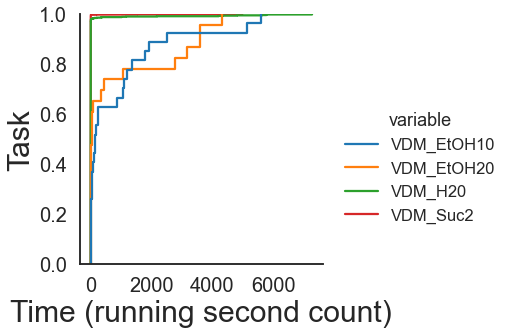

In [44]:
plt.figure(figsize=(10,10))
params = {'axes.labelsize': 30,
          'axes.titlesize': 30}
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams.update(params)

data_int = data_comb[data_comb['VDM_hour']==18]
sns.displot(data=data_int, x="VDM_RFID_timediff", kind="ecdf", hue='variable')
plt.xlabel('Time (running second count)')
plt.ylabel('Task')
plt.show()

### Export data

In [45]:
data_VDM_tidy_intake.to_csv('data_VDM_tidy_intake_1m_suc.csv')
data_RFID_final.to_csv('data_RFID_final_1m_suc.csv')
data_comb.to_csv('data_comb_1m_suc.csv')